In [1]:
#%matplotlib notebook
import functools
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from sympy import *
init_printing()

In [2]:
theta, phi = symbols('theta, phi', real=True)

In [3]:
@functools.lru_cache(maxsize=4096)
def Pmm(m, x):
    if m <= 0:
        return Number(1)
    fact = Number(2*m - 1)
    pmm = Number(-1)**m * fact * sqrt(1-x**2) * Pmm(m-1, x)
    return pmm.simplify()

@functools.lru_cache(maxsize=4096)
def Pmmp1(m, x):
    pmmp1 = x * (2*m + 1) * Pmm(m, x)
    return pmmp1.simplify()

@functools.lru_cache(maxsize=4096)
def P(l, m, x):
    if l == m:
        return Pmm(m, x)
    if l == m+1:
        return Pmmp1(m, x)
    pll = ((2*l-1) * x * P(l-1, m, x) - (l+m-1) * P(l-2, m, x)) / (l-m)
    return pll.simplify()

In [4]:
@functools.lru_cache(maxsize=4096)
def K(l, m):
    return sqrt(((2*l+1)/(4*pi))*(factorial(l-m)/factorial(l+m))).simplify()

In [5]:
@functools.lru_cache(maxsize=4096)
def SH(l, m, theta, phi):
    if m > 0:
        return sqrt(2)*K(l,m)*cos(m*phi)*P(l,m,cos(theta))
    elif m < 0:
        return sqrt(2)*K(l,-m)*sin(-m*phi)*P(l,-m,cos(theta))
    else:
        return K(l,m)*P(l,m,cos(theta))

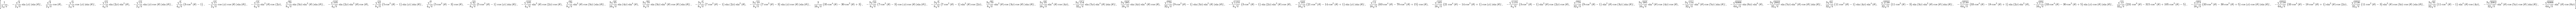

In [6]:
SHs = []
SHs_names = []
for l in range(7):
    for m in range(-l, l+1):
        SHs.append(SH(l, m, theta, phi).simplify())
        SHs_names.append(f"SH(l={l},m={m})")
SHs

In [7]:
SHs_dtheta = [sh.diff(theta).simplify() for sh in SHs]

In [8]:
SHs_dphi = [sh.diff(phi).simplify() for sh in SHs]

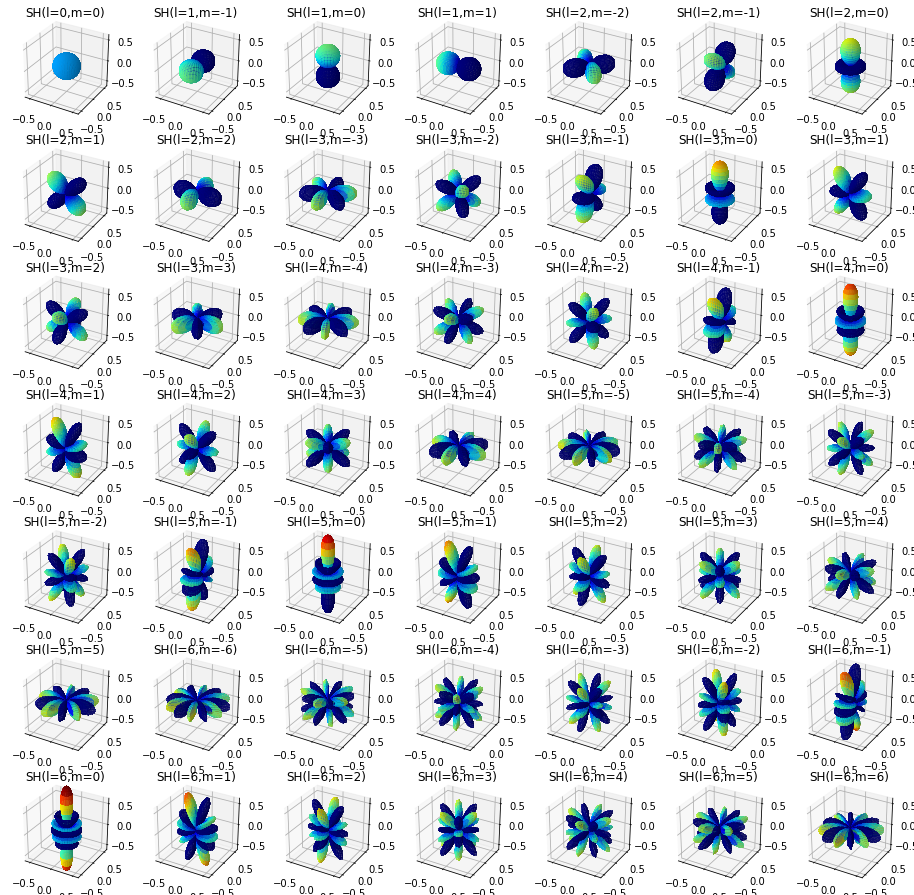

In [9]:
fig = plt.figure(figsize=(16,16))
theta_, phi_ = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
theta_, phi_ = np.pi*theta_, 2*np.pi*phi_
THETA, PHI = np.meshgrid(theta_, phi_)
plot_dim = int(np.ceil(len(SHs)**0.5))
plot_lim = 0.6
for i in range(len(SHs)):
    lambda_sh = lambdify((theta,phi), SHs[i].evalf())
    R = lambda_sh(THETA, PHI) + np.zeros_like(THETA)
    X = np.sin(THETA) * np.cos(PHI)
    Y = np.sin(THETA) * np.sin(PHI)
    Z = np.cos(THETA)
    ax = fig.add_subplot(plot_dim,plot_dim,i+1, projection='3d')
    ax.set_title(SHs_names[i])
    ax.set_xlim((-plot_lim,plot_lim))
    ax.set_ylim((-plot_lim,plot_lim))
    ax.set_zlim((-plot_lim,plot_lim))
    ax.plot_surface(
        abs(R)*X, abs(R)*Y, abs(R)*Z,
        rstride=1, cstride=1,
        facecolors=plt.cm.jet(R),
        linewidth=0, antialiased=False, alpha=0.5)
plt.show()

In [10]:
def original(x, y, z):
    r = np.exp(1j*(np.sin(x*3+np.cos(y*4)+np.sin(z*5))))
    return np.real(r)

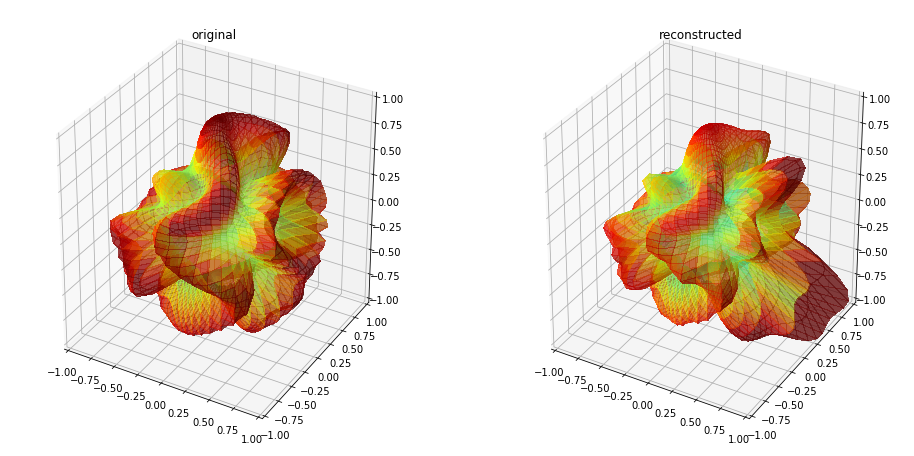

In [11]:
fig = plt.figure(figsize=(16,8))
theta_, phi_ = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
theta_, phi_ = np.pi*theta_, 2*np.pi*phi_
THETA, PHI = np.meshgrid(theta_, phi_)
plot_lim = 1.
X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)
lambda_shs = []
C = []
O = original(X,Y,Z)
for l in range(16):
    for m in range(-l, l+1):
        lambda_sh = lambdify((theta,phi), SH(l,m,theta,phi).simplify().evalf())
        c = 6*np.pi*np.mean(original(X,Y,Z) * lambda_sh(THETA, PHI) * np.sin(THETA))
        C.append(c)
        lambda_shs.append(lambda_sh)
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_title("original")
ax.set_xlim((-plot_lim,plot_lim))
ax.set_ylim((-plot_lim,plot_lim))
ax.set_zlim((-plot_lim,plot_lim))
ax.plot_surface(
    abs(O)*X, abs(O)*Y, abs(O)*Z,
    rstride=1, cstride=1,
    facecolors=plt.cm.jet(O),
    linewidth=0, antialiased=False, alpha=0.5)
R = np.zeros_like(THETA)
for i in range(len(lambda_shs)):
    R += C[i] * lambda_shs[i](THETA, PHI)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.set_title("reconstructed")
ax.set_xlim((-plot_lim,plot_lim))
ax.set_ylim((-plot_lim,plot_lim))
ax.set_zlim((-plot_lim,plot_lim))
ax.plot_surface(
    abs(R)*X, abs(R)*Y, abs(R)*Z,
    rstride=1, cstride=1,
    facecolors=plt.cm.jet(R),
    linewidth=0, antialiased=False, alpha=0.5)
plt.show()

### the above method has two inconvenience
- there is a sin(theta) in the spherical harmonic integration step
- there is a 6*PI which is a sampling point distribution depended constant in the reconstruction step

I want to get rid of them with deep learning

In [12]:
import keras

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
class SphericalHarmonic(keras.layers.Layer):
    
    def __init__(self, units, bands=4, ** kwargs):
        self.units = units
        self.bands = bands
        super(SphericalHarmonic, self).__init__(**kwargs)
    
    def build(self, input_shape):
        if input_shape[-1] != 2:
            raise Exception("last dimension of the input must be (theta, phi)")
        self.coff = self.add_weight(
            shape=(1, self.units, self.bands*self.bands),
            initializer='uniform', name='coff')
        self.__SHs = []
        for l in range(self.bands):
            for m in range(-l, l+1):
                sym_SH = SH(l, m, theta, phi).simplify()
                tf_SH = lambdify((theta, phi), sym_SH.evalf(),
                                 modules=['tensorflow','numpy'])
                self.__SHs.append(tf_SH)
        super(SphericalHarmonic, self).build(input_shape)
    
    def call(self, inputs):
        THETA, PHI = inputs[:,0:1], inputs[:,1:2]
        R = self.__SHs[0](THETA, PHI) * self.coff[:,:,0]
        for i in range(1, len(self.__SHs)):
            R += self.__SHs[i](THETA, PHI) * self.coff[:,:,i]
        return R
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [14]:
X = X_input = keras.layers.Input((2,))
X = SphericalHarmonic(1, bands=16)(X)
M = keras.Model(X_input, X)
M.compile('adam', 'mse')
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
spherical_harmonic_1 (Spheri (None, 1)                 256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [15]:
theta_, phi_ = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
theta_, phi_ = np.pi*theta_, 2*np.pi*phi_
THETA, PHI = np.meshgrid(theta_, phi_)
X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)
O = original(X,Y,Z)
M.fit(np.hstack([
    np.reshape(THETA, [-1])[:,np.newaxis],
    np.reshape(PHI, [-1])[:,np.newaxis]]), \
    np.reshape(O, [-1])[:,np.newaxis], batch_size=64, epochs=1000, callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=True),
        keras.callbacks.EarlyStopping(monitor='loss'),
    ])

Epoch 1/1000
2500/2500 [==============================] - 4s 1ms/step - loss: 0.6041
Epoch 2/1000
2500/2500 [==============================] - 1s 346us/step - loss: 0.5421
Epoch 3/1000
2500/2500 [==============================] - 1s 327us/step - loss: 0.5031
Epoch 4/1000
2500/2500 [==============================] - 1s 342us/step - loss: 0.4754
Epoch 5/1000
2500/2500 [==============================] - 1s 345us/step - loss: 0.4529
Epoch 6/1000
2500/2500 [==============================] - 1s 344us/step - loss: 0.4329
Epoch 7/1000
2500/2500 [==============================] - 1s 323us/step - loss: 0.4148
Epoch 8/1000
2500/2500 [==============================] - 1s 329us/step - loss: 0.3979
Epoch 9/1000
2500/2500 [==============================] - 1s 325us/step - loss: 0.3821
Epoch 10/1000
2500/2500 [==============================] - 1s 325us/step - loss: 0.3674
Epoch 11/1000
2500/2500 [==============================] - 1s 328us/step - loss: 0.3534
Epoch 12/1000
2500/2500 [==================

2500/2500 [==============================] - 1s 337us/step - loss: 0.0047
Epoch 95/1000
2500/2500 [==============================] - 1s 341us/step - loss: 0.0043
Epoch 96/1000
2500/2500 [==============================] - 1s 341us/step - loss: 0.0039
Epoch 97/1000
2500/2500 [==============================] - 1s 333us/step - loss: 0.0036
Epoch 98/1000
2500/2500 [==============================] - 1s 332us/step - loss: 0.0032
Epoch 99/1000
2500/2500 [==============================] - 1s 332us/step - loss: 0.0029
Epoch 100/1000
2500/2500 [==============================] - 1s 336us/step - loss: 0.0027
Epoch 101/1000
2500/2500 [==============================] - 1s 336us/step - loss: 0.0024
Epoch 102/1000
2500/2500 [==============================] - 1s 328us/step - loss: 0.0022
Epoch 103/1000
2500/2500 [==============================] - 1s 332us/step - loss: 0.0020
Epoch 104/1000
2500/2500 [==============================] - 1s 344us/step - loss: 0.0018
Epoch 105/1000
2500/2500 [===============

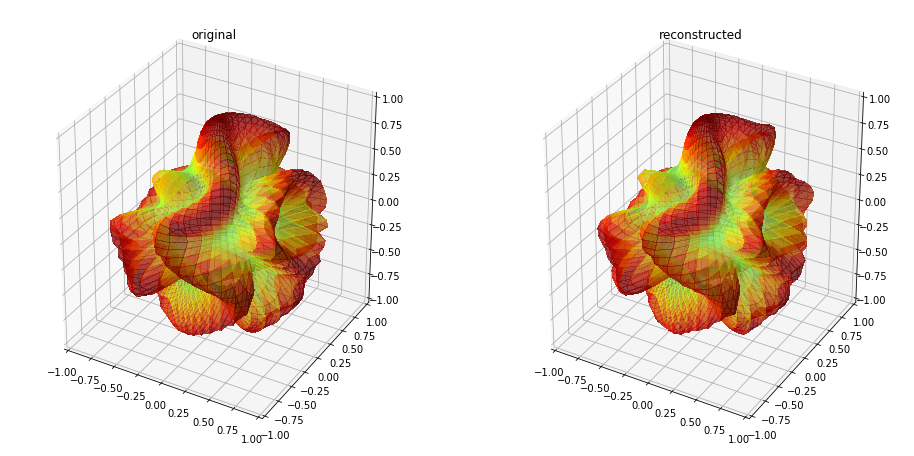

In [16]:
R = M.predict(np.hstack([
    np.reshape(THETA, [-1])[:,np.newaxis],
    np.reshape(PHI, [-1])[:,np.newaxis]]))
R = np.reshape(R, O.shape)
fig = plt.figure(figsize=(16,8))
plot_lim = 1.
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_title("original")
ax.set_xlim((-plot_lim,plot_lim))
ax.set_ylim((-plot_lim,plot_lim))
ax.set_zlim((-plot_lim,plot_lim))
ax.plot_surface(
    abs(O)*X, abs(O)*Y, abs(O)*Z,
    rstride=1, cstride=1,
    facecolors=plt.cm.jet(O),
    linewidth=0, antialiased=False, alpha=0.5)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.set_title("reconstructed")
ax.set_xlim((-plot_lim,plot_lim))
ax.set_ylim((-plot_lim,plot_lim))
ax.set_zlim((-plot_lim,plot_lim))
ax.plot_surface(
    abs(R)*X, abs(R)*Y, abs(R)*Z,
    rstride=1, cstride=1,
    facecolors=plt.cm.jet(R),
    linewidth=0, antialiased=False, alpha=0.5)
plt.show()